In [2]:
# import all stuff we will need
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.io as sio

from scipy.optimize import curve_fit
from gbm_d import gbm_d
from barrier_bs import barrier_bs
from yf import yf

# 6.1 Payoff and profit

The payoff of a barrier reverse convertible written on one underlying is

\begin{equation*}
g(S_T)=C^m+N-nI^c\max\{X-S_T,0\}
\end{equation*}

with $I^c=1-I$ and

\begin{equation*}
I:=1_{\{T<\tau_G\}}:=\left\{\begin{array}{ll}1 & {\rm if}\;\;T< \tau_G \\ 0 & {\rm else}\end{array}\right.
\end{equation*}

where $G=]B,\infty[$. Furthermore, $n=\frac{N}{X}$ is the coversion ratio and $C^m$ is the final value (at maturity $t=T$) of all coupon payments made at times $T_i$, i.e.,

\begin{equation*}
C^m=C\sum_{i=1}^me^{r(T-T_i)}\;.
\end{equation*}


Usually, the issue price of the product is $V_{\rm brc}(s,0)=N$, whence the profit $P(S_T)$ is

\begin{equation*}
P(S_T)=C^m-nI^c\max\{X-S_T,0\}\;.
\end{equation*} 

# 6.2 Replication and pricing

In [ ]:
We replicate the payoff $g$. The cash flow $C^m+N$ can be generated by a riskless investment into the money market with continuously compounding interest rate $r$. The present value of $C^m+N$ at time $t\leq T$ is thus

\begin{equation*}
e^{-r(T-t)}(C^m+N)\;.
\end{equation*}

The cash flow $I^c\max\{X-S_T,0\}$ corresponds to the payoff of a down-and-in put option. If the barrier $B<S_0$ is hit during the life time of the BRC, then the down-and-in put pays off $\max\{X-S_T,0\}$, which is the payoff of a European put. If, however, the underlying does not reach the barrier, the down-and-in option becomes worthless. The value of the down-and-in put is given as

\begin{equation*}
V_{p,{\rm di}}(s,t)=V_p(s,t)-V_{p,{\rm do}}(s,t)\;;
\end{equation*}

we realised this formula already in the Python function <span style="color:orange">barrier_bs.py</span>. Hence, the term $-nI^c\max\{X-S_T,0\}$ corresponds to a short position in $n$ down-and-in puts such that for $0\leq t\leq T$ the value $V_{\rm brc}(s,t)$ of the BRC must be

\begin{equation*}
V_{\rm brc}(s,t)=e^{-r(T-t)}(C^m+N)-nV_{p,{\rm di}}(s,t)\;.
\end{equation*}

### Example 6.1

We check the market price $V^{\rm M}_{\rm brc}=1041 / 1046$ (bid/ask) of the BRC on the Nestle (compare with the figure below) as of August $26$, $2019$ ($t=0$). 

<img src="BRC_JB_1.jpg" alt="Drawing" style="width: 600px;"/>
<img src="BRC_JB_2.jpg" alt="Drawing" style="width: 600px;"/>

We take the following data: $s=107.96$ (value Nestle), $\sigma=19.34\%$, $q=\ln(1+0.0168)$, $r=-0.96\%$, (values for $\sigma$, $r$ and $q$ are from Bloomberg) and the maturity $t=T$ corresponds to $26/2/2021$. The remaining data are taken from the term sheet. In particular, the coupon payment dates $T_i$ are $T_1=5/9/2019$, $T_2=5/3/2020$, $T_3=7/9/2020$ and $T_4=5/3/2021$. We use the function <span style="color:orange">yf.py</span> to calculate the time spans $T-T_i$ in the evaluation of the final value  $C^m$ of the coupon payments. The value $V_{p,{\rm di}}$ follows from the Python function <span style="color:orange">barrier_bs.py</span>.

In [3]:
# time-to-maturity, time-to-coupon payments
T = yf((26,8,2019),[(26,2,2021)])[0] 
Ti = yf((26,8,2019),[(5,9,2019),(5,3,2020),(7,9,2020),(5,3,2021)])

# the value of the down-and-in put
s = 107.96; B = 68.445; X = 91.26; r = -0.0096; q = np.log(1+0.0168)
Vpdi = barrier_bs(s,B,X,T,0.1934,r,q)[1]

# final value of the coupon payments
Cm = 13.75*np.sum(np.exp(r*(T-Ti)))

# the value of the BRC
V = np.exp(-r*T)*(Cm+1000)-1000/X*Vpdi

In [4]:
Vpdi, V

(2.183441388762827, 1045.9909411537612)

We are now interested in the time evolution $t\mapsto V_{\rm brc}(s,t)$ of the value of the BRC in the above example. To understand it, we simulate the (value of the) underlying $S_t$ for $0<t\leq 0.5$ as a geometric Brownian motion, where we take $t=0$ to be the date $26/2/2019$ of initial fixing (such that $S_0=X=91.26$). The model parameters of the geometric Brownian motion are $\mu=0\%$ (we expect a sideway moving underlying), $\sigma=16.5\%$; for the risk-neutral pricing with take $q=\ln(1+0.018)$ and $r=\ln(1-0.0073)$. 

We simulate one path $(t_j,S_{t_j})$ of the underlying using <span style="color:orange">gbm_d.py</span>. For each $t_j$ we calculate the value $v_j=V_{\rm brc}(S_{t_j},t_j)$ of the BRC in dependence on $S_{t_j}$ and $t_j$; we implicitly assume that the model parameters $\sigma,\mu$ and $r$ do not change over time. Then we plot the normalised values $(t_j,S_{t_j}/S_0)$ and $(t_j,v_j/V_{\rm brc}(S_0,0))$.

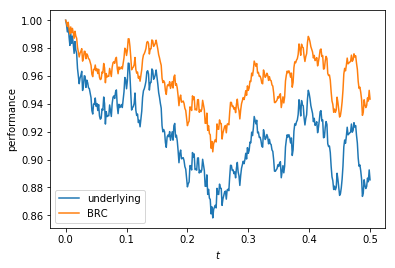

In [5]:
S, t = gbm_d(s0=[91.26],Sigma=[[0.165**2]],mu=[0],T=0.5,Tau=[],dt=1/720) # the stock price

# time-to-maturity, time-to-coupon payments
T = yf((26,2,2019),[(26,2,2021)])[0] 
Ti = yf((26,2,2019),[(5,9,2019),(5,3,2020),(7,9,2020),(5,3,2021)])

# final value of the coupon payments
Cm = 13.75*np.sum(np.exp(r*(T-Ti)))

# the value of the down-and-in put
B = 68.445; X = 91.26; r = np.log(1-0.0073); q = np.log(1+0.018)
Vpdi = barrier_bs(S,B,X,T-t,0.165,r,q)[1]

# the value of the BRC
Vbrc = np.exp(-r*(T-t))*(Cm+1000)-1000/X*Vpdi
plt.plot(t,S/S[0],t,Vbrc/Vbrc[0]);
plt.xlabel('$t$'); plt.ylabel('performance')
plt.legend(('underlying','BRC'));

# 6.3 Multi barrier reverse convertibles

The payoff function of multi barrier reverse convertibles is

\begin{eqnarray*}
g({\bf S}_T) &=& C^m+N-NI^c\max\Big\{\max_i\frac{ X_i-S^i_T}{X_i},0\Big\}\\
& = & C^m+N-NI^c\max\Big\{1-\min_i\frac{ S^i_T}{X_i},0\Big\}\;,
\end{eqnarray*}

where ${\bf S}_t=(S^1_t,\ldots,S^d_t)$ is the vector of the stock prices and $X_i$ is the strike price of the $i$-th underlying. From the considerations made in the previous section it follows that the value $V_{\rm mbrc}$ of a MBRC is given by 

\begin{equation}\label{eq:value_mbrc}
V_{\rm mbrc}({\bf s},t)=e^{-r(T-t)}(C^m+N)-NV_{p,{\rm di},d}({\bf s},t),
\end{equation}

where we denote by $V_{p,{\rm di},d}({\bf s},t)$ the time $t$-value of a down-and-in put on $d$ stocks with prices ${\bf s}=(s_1,\ldots,s_d)$. To calculate this value we model the stock prices ${\bf S}_t$ as a $d$-dimensional geometric Brownian motion. As in the case of a basket bonus certificate in chapter 5 the value $V_{p,{\rm di},d}({\bf s},t)$ can not be found analytically and we have to rely on numerical approximations. We use the function <span style="color:orange">gbm_d.py</span> to find the price. 

In [ ]:
### Example 6.2 

On June $13$, $2019$, ($t=0$) we check the issue price $1000$ CHF of the MBRC with $6.25\%$ p.a. coupon and $65\%$ barrier on CS and UBS given in the figure beloe.

<img src="MBRC_ZKB_1.jpg" alt="Drawing" style="width: 600px;"/>
<img src="MBRC_ZKB_2.jpg" alt="Drawing" style="width: 600px;"/>


We take the values $s_1=X_1=11.47$ CHF (CS), $s_2=X_2=11.655$ (UBS), $B_1=7.4555=0.65s_1$, $B_2=7.5758=0.65s_2$, $r=-0.735\%$. The continuous dividend yields are $q_1=\ln(1.03547)$ (CS) and $q_2=\ln(1.07783)$ (UBS). The implied volatilities are $\boldsymbol{\sigma}^{\textrm{i}}=\textrm{diag}(\sigma_1^\textrm{i},\sigma_2^\textrm{i})=\textrm{diag}(0.226,0.204)$, the correlation matrix $\boldsymbol{\rho}$ is 

\begin{equation*}
\boldsymbol{\rho}=\boldsymbol{\rho}^{\textrm{h}}=\begin{pmatrix}1& \rho \\ & 1\end{pmatrix}=\begin{pmatrix}1& 0.856 \\ & 1\end{pmatrix}\;.
\end{equation*}

The remaining data is from the term sheet; time spans are calculated using <span style="color:orange">yf.py</span>.

In [6]:
# input parameters (model, contract)
s0 = [11.47,11.655]; q = [np.log(1.03547),np.log(1.07783)]; r = -0.00735
sigma = np.diag([0.226,0.204]); rho = np.array([[1,0.856],[0,1]]); 
rho = rho+rho.T-np.eye(2); Sigma = sigma.dot(rho).dot(sigma)
B = [7.4555,7.5758]; X = [11.47,11.655]; N = 1000
T = yf((13,6,2019),[(11,6,2021)]); Ti = yf((13,6,2019),[(18,6,2020),(18,6,2021)])
mu = [r-x for x in q]; q = np.reshape(np.asarray(q),[2,1])
B = np.reshape(np.asarray(B),[2,1]); X = np.reshape(np.asarray(X),[2,1])

# input parameters (Monte Carlo simulation)
n = 10**5; dt = 1/(16*252); v = np.zeros(n)

In [7]:
# Monte Carlo simulation
for j in range(0,n):
    D = gbm_d(s0,mu,Sigma,[],T,dt) 
    S = D[0][1:] # simulated stock prices, excluding s0
    # the minimium stock prices
    Smin = np.amin(S,axis=0); Smin = Smin.reshape(len(s0),1)
    ST = S[-1,:]; ST = ST.reshape(len(s0),1)
    
    if np.any(Smin-B<=0): # barrier hit?
        v[j] = np.maximum(1-np.min(ST/X),0) 

Vpdi = np.exp(-r*T)*np.mean(v)

In [8]:
# final value of the coupon payments
Cm = 0.0625*N*np.sum(np.exp(r*(T-Ti)))
# the value of the BRC
V = np.exp(-r*T)*(Cm+N)-N*Vpdi; display((V[0],Vpdi[0]))

(986.0457759133783, 0.15512086928201807)